In [8]:
import pandas as pd
import numpy as np
from pathlib import Path

data = pd.read_csv("data/dataset.csv")


feature_list = [
    item for item in Path("features_list.txt").read_text().split("\n") if item
]

In [9]:
data.drop(data.loc[data["def_45"].isna()].index, inplace=True)

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import re


class Preprocessor:
    feature_list: list[str]
    column_transformer: ColumnTransformer
    exclude_cols: list[str]
    categorized_columns: dict[str, list[str]]

    def __init__(self, feature_list: list[str], exclude_cols: list[str]) -> None:
        self.feature_list = feature_list
        self.exclude_cols = exclude_cols

    def _init_transformer_params(self) -> None:
        self.transformer_params = {
            "transformers": [
                ("cats", OrdinalEncoder(), self.categorized_columns.get("categorical")),
                (
                    "numscaler",
                    StandardScaler(),
                    self.categorized_columns.get("numeric"),
                ),
            ],
            "remainder": "passthrough",
            "verbose": True,
        }

    def _train_transformer(self, data: pd.DataFrame) -> None:
        self._init_transformer_params()
        self.column_transformer = ColumnTransformer(**self.transformer_params)
        self.column_transformer.fit(data)

    def _categorize_columns(self, data: pd.DataFrame) -> None:
        numeric_cols = []
        boolean_cols = []
        categorical_cols = []

        for col in data.columns:
            # Булевые (bool или содержат только 0/1, True/False)
            if data[col].dtype == "bool":
                boolean_cols.append(col)
            # Числовые (int, float)
            elif pd.api.types.is_numeric_dtype(data[col]):
                # Проверяем, не является ли числовая колонка на самом деле булевой
                unique_vals = data[col].dropna().unique()
                if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
                    boolean_cols.append(col)
                else:
                    numeric_cols.append(col)
            # Категориальные (object, category, datetime)
            else:
                categorical_cols.append(col)

        self.categorized_columns = {
            "numeric": numeric_cols,
            "boolean": boolean_cols,
            "categorical": categorical_cols,
        }

    @staticmethod
    def _remove_duplicates(data: pd.DataFrame) -> pd.DataFrame:
        return data.drop_duplicates()

    @staticmethod
    def _fill_missing_values(
        data: pd.DataFrame, num_cols: list[str], cat_cols: list[str]
    ) -> pd.DataFrame:
        data = data.copy()

        for col in num_cols:
            if data[col].isna().any():
                data[col].fillna(data[col].mean(), inplace=True)

        for col in cat_cols:
            if data[col].isna().any():
                mode_value = data[col].mode()
                if not mode_value.empty:
                    data[col].fillna(mode_value.iloc[0], inplace=True)

        return data

    @staticmethod
    def _remove_prefixes(columns: list[str]) -> list[str]:
        pattern = r"^(cats__|numscaler__|remainder__)"
        return [re.sub(pattern, "", col) for col in columns]

    def transform_data(self, data: pd.DataFrame) -> pd.DataFrame:
        step_0 = data[self.feature_list].copy()

        # Сохраняем excluded колонки ДО обработки
        excluded_data = step_0[self.exclude_cols].copy()

        self._categorize_columns(step_0.drop(columns=self.exclude_cols))

        step_1 = self._remove_duplicates(step_0.drop(columns=self.exclude_cols))

        # Сохраняем индексы после удаления дубликатов
        valid_indices = step_1.index

        step_2 = self._fill_missing_values(
            step_1,
            self.categorized_columns.get("numeric"),
            self.categorized_columns.get("categorical"),
        )

        # Добавляем excluded колонки ТОЛЬКО для сохранившихся индексов
        for col in self.exclude_cols:
            step_2[col] = excluded_data.loc[valid_indices, col].values

        self._train_transformer(step_2)

        step_3_array = self.column_transformer.transform(step_2)
        step_3 = pd.DataFrame(
            step_3_array,
            columns=self._remove_prefixes(
                self.column_transformer.get_feature_names_out()
            ),
        )

        return step_3

In [11]:
train_preprocessor = Preprocessor(
    feature_list=feature_list, exclude_cols=["application_datetime", "def_45"]
)

test_preprocessor = Preprocessor(
    feature_list=feature_list, exclude_cols=["application_datetime", "def_45"]
)

valid_preprocessor = Preprocessor(
    feature_list=feature_list, exclude_cols=["application_datetime", "def_45"]
)

In [12]:
from utils import split_data


train_valid, test = split_data(data, split_column="application_datetime", ratio=0.8)


train, valid = split_data(train_valid, split_column="application_datetime", ratio=0.8)

del train_valid

In [13]:
train = train_preprocessor.transform_data(train)
test = test_preprocessor.transform_data(test)
valid = valid_preprocessor.transform_data(valid)

[ColumnTransformer] ..... (1 of 2) Processing numscaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[ColumnTransformer] ..... (1 of 2) Processing numscaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[ColumnTransformer] ..... (1 of 2) Processing numscaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


/tmp/ipykernel_92146/1670700594.py:74: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
/tmp/ipykernel_92146/1670700594.py:74: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [14]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import get_scorer_names, roc_auc_score, roc_curve
from catboost import CatBoostClassifier, Pool

cat_features = train_preprocessor.categorized_columns.get("categorical")
train_target = train.pop("def_45")
valid_target = valid.pop("def_45")
test_target = test.pop("def_45")


train_pool = Pool(
    train.drop(columns=["application_datetime"]),
    label=train_target,
    cat_features=cat_features,
)

valid_pool = Pool(
    valid.drop(columns=["application_datetime"]),
    label=valid_target,
    cat_features=cat_features,
)

test_pool = Pool(
    test.drop(columns=["application_datetime"]),
    label=test_target,
    cat_features=cat_features,
)

In [15]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    random_seed=42,
    auto_class_weights="Balanced",
    early_stopping_rounds=50,
    eval_metric="AUC",
    verbose=100,
)

model.fit(train_pool)

0:	total: 58.7ms	remaining: 58.6s
100:	total: 220ms	remaining: 1.96s
200:	total: 379ms	remaining: 1.51s
300:	total: 532ms	remaining: 1.23s
400:	total: 673ms	remaining: 1s
500:	total: 837ms	remaining: 834ms
600:	total: 989ms	remaining: 657ms
700:	total: 1.13s	remaining: 483ms
800:	total: 1.29s	remaining: 320ms
900:	total: 1.44s	remaining: 158ms
999:	total: 1.58s	remaining: 0us


In [16]:
p_v = model.predict(valid_pool)
print("ROC AUC: ", roc_auc_score(valid_target.to_list(), p_v))

ROC AUC:  0.9818424137799893


In [17]:
p_t = model.predict(test_pool)
print("ROC AUC: ", roc_auc_score(test_target.to_list(), p_t))

ROC AUC:  0.9900197628458498


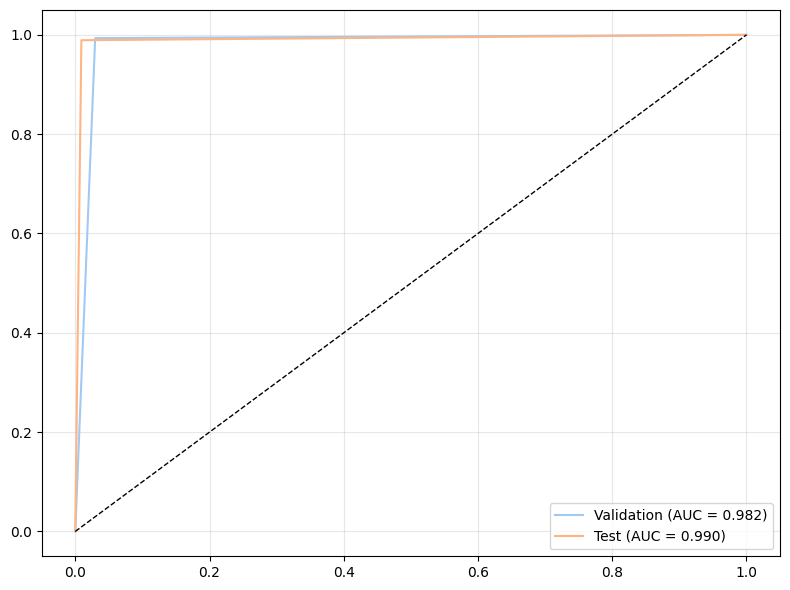

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

fig = plt.figure(figsize=(8, 6))


valid_fpr, valid_tpr, _ = roc_curve(valid_target.to_list(), p_v)
test_fpr, test_tpr, _ = roc_curve(test_target.to_list(), p_t)

# Вычисляем AUC для отображения в легенде
valid_auc = auc(valid_fpr, valid_tpr)
test_auc = auc(test_fpr, test_tpr)

# Устанавливаем палитру
sns.set_palette("pastel")

sns.lineplot(x=valid_fpr, y=valid_tpr, label=f"Validation (AUC = {valid_auc:.3f})")
sns.lineplot(x=test_fpr, y=test_tpr, label=f"Test (AUC = {test_auc:.3f})")

# Добавляем диагональную линию (случайный классификатор)
plt.plot([0, 1], [0, 1], "k--", lw=1, label="Random (AUC = 0.5)")

# Настройки графика

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Обучение модели, валидация
Как валидировать? Как тестировать? В чём отличие?)

Ответ: Валидационная выборка нужна для того, чтобы отслеживать стабильность в обучении модели во время подбора гиперпараметров и тестирования. Тестовая выборка нужна для итоговой оценки качества модели на новых данных.

Фукнции валидации:
- Отслеживание переобучения
- Выбор оптимальных гиперпараметров
- Сравнение разных архитектур моделей

Функции тестовой выборки:
- Объективная оценка производительности на "невиденных" данных
- Оценка способности модели к генерализации

Переделаем предикт в score и посмотрим распределение на тестовой выборке

In [19]:
test_probas = model.predict_proba(test_pool)

Доменная область скоринга

In [20]:
test_scores = (test_probas[:, 1] * 1000).astype(np.int16)

test["model_score"] = test_scores
test["resolution"] = test_target

In [21]:
test.head()

,avg_loan_term_months,credit_score_volatility_3y,OKB_score,antibankrupt_score,avg_time_since_account_open,num_loans_with_guarantor,total_interest_paid_5y,gamma_refactor_pod,proportion_salary_deposited,num_late_payments_last_24m_7,...,monthly_payment_burden,num_settled_defaults_5y_194,frequency_of_balance_transfers_2y,id_2804_foo,id_7438_quux,id_9625_foo,max_utilization_single_card_half,application_datetime,model_score,resolution
0,-1.747944,-0.09615,0.702169,0.585609,0.263496,-0.052499,-0.062575,0.391485,-1.487229,0.0,...,-0.14955,0.0,0.414412,1,0,0,NaN,2024-04-06 00:08:29,998,1
1,-0.977668,0.546555,-0.539779,0.08769,0.263496,2.325138,-0.086941,0.072094,-0.19106,0.0,...,-0.14955,-6.186836,-0.281972,1,1,1,0.0,2024-04-06 00:53:52,998,1
2,-0.003496,0.12497,0.531092,0.004703,0.263496,-0.052499,0.017955,-0.760828,0.26344,0.0,...,-0.14955,0.0,0.414412,1,0,0,NaN,2024-04-06 01:30:35,999,1
3,-2.223702,-0.183508,-0.086742,0.004703,0.263496,-1.241318,-0.050433,-1.966536,-1.861772,0.0,...,-0.14955,0.0,0.414412,0,1,1,1.0,2024-04-06 02:13:19,999,1
4,-0.248927,0.944356,-0.49797,0.502623,0.263496,-0.052499,-0.022188,-0.043433,0.120357,0.0,...,-0.14955,0.0,0.414412,1,0,1,0.0,2024-04-06 03:33:07,998,1


In [22]:
print(
    "Высокая уверенность, но все равно отказ(score > 500):",
    test.query("model_score > 500 and resolution ==0").shape[0],
)
print(
    "Низкая уверенность, но все равно одобрили (score < 500):",
    test.query("model_score < 500 and resolution ==1").shape[0],
)
print(
    "Высокая уверенность и одобрили (score > 500):",
    test.query("model_score > 500 and resolution ==1").shape[0],
)
print(
    "Низкая уверенность и отказ (score < 500):",
    test.query("model_score < 500 and resolution ==0").shape[0],
)
print("Общее число юзеров:", test.shape[0])

Высокая уверенность, но все равно отказ(score > 500): 11
Низкая уверенность, но все равно одобрили (score < 500): 9
Высокая уверенность и одобрили (score > 500): 819
Низкая уверенность и отказ (score < 500): 1199
Общее число юзеров: 2038


In [23]:
test["model_score"].describe()

count    2038.000000
mean      404.898430
std       477.814701
min         0.000000
25%         0.000000
50%         6.000000
75%       996.000000
max       999.000000
Name: model_score, dtype: float64

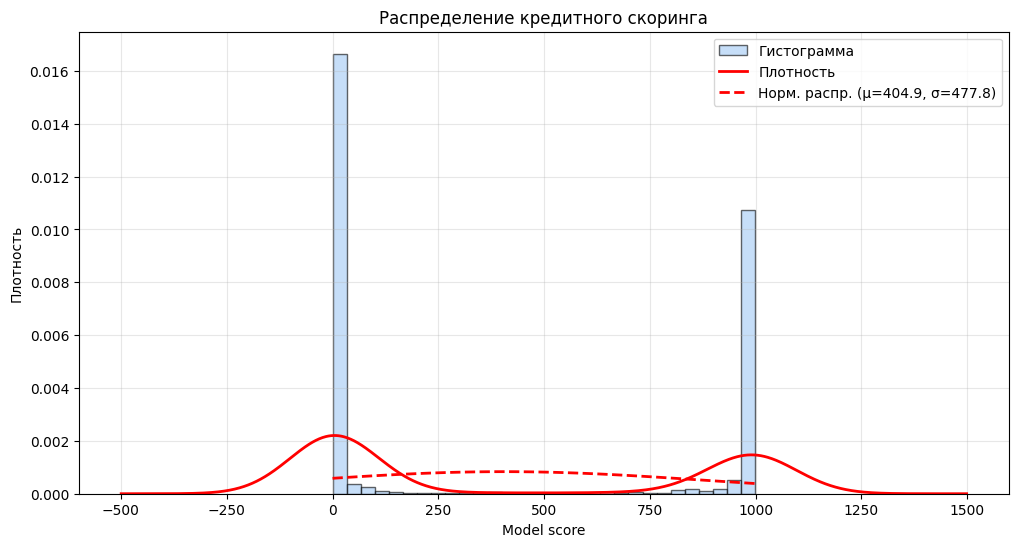

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

fig = plt.figure(figsize=(12, 6))


# Гистограмма + плотность распределения
test["model_score"].plot(
    kind="hist",
    bins=30,
    density=True,  # нормализация для наложения KDE
    alpha=0.6,
    edgecolor="black",
    label="Гистограмма",
)

# Добавляем KDE
test["model_score"].plot(kind="kde", linewidth=2, color="red", label="Плотность")


# Нормальное распределение (пунктирная линия)
mu = test["model_score"].mean()
sigma = test["model_score"].std()
x = np.linspace(
    test["model_score"].min(),
    test["model_score"].max(),
    100,
)
normal_dist = stats.norm.pdf(x, mu, sigma)

plt.plot(
    x,
    normal_dist,
    "r--",  # красная пунктирная линия
    linewidth=2,
    label=f"Норм. распр. (μ={mu:.1f}, σ={sigma:.1f})",
)


plt.xlabel("Model score")
plt.ylabel("Плотность")
plt.title("Распределение кредитного скоринга")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Попробуем понять чо происходит на дне, неделе и месяце

In [25]:
test_with_dates = test.copy()

In [26]:
test_with_dates["application_datetime"] = pd.to_datetime(test["application_datetime"])

test_with_dates["week"] = test_with_dates["application_datetime"].dt.isocalendar().week

test_with_dates["day"] = test_with_dates["application_datetime"].dt.day

test_with_dates["day_of_year"] = test_with_dates["application_datetime"].dt.dayofyear

In [27]:
test_with_dates

,avg_loan_term_months,credit_score_volatility_3y,OKB_score,antibankrupt_score,avg_time_since_account_open,num_loans_with_guarantor,total_interest_paid_5y,gamma_refactor_pod,proportion_salary_deposited,num_late_payments_last_24m_7,...,id_2804_foo,id_7438_quux,id_9625_foo,max_utilization_single_card_half,application_datetime,model_score,resolution,week,day,day_of_year
0,-1.747944,-0.09615,0.702169,0.585609,0.263496,-0.052499,-0.062575,0.391485,-1.487229,0.0,...,1,0,0,NaN,2024-04-06 00:08:29,998,1,14,6,97
1,-0.977668,0.546555,-0.539779,0.08769,0.263496,2.325138,-0.086941,0.072094,-0.19106,0.0,...,1,1,1,0.0,2024-04-06 00:53:52,998,1,14,6,97
2,-0.003496,0.12497,0.531092,0.004703,0.263496,-0.052499,0.017955,-0.760828,0.26344,0.0,...,1,0,0,NaN,2024-04-06 01:30:35,999,1,14,6,97
3,-2.223702,-0.183508,-0.086742,0.004703,0.263496,-1.241318,-0.050433,-1.966536,-1.861772,0.0,...,0,1,1,1.0,2024-04-06 02:13:19,999,1,14,6,97
4,-0.248927,0.944356,-0.49797,0.502623,0.263496,-0.052499,-0.022188,-0.043433,0.120357,0.0,...,1,0,1,0.0,2024-04-06 03:33:07,998,1,14,6,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033,-0.199841,-0.151406,-0.984553,-1.779508,0.007374,-0.052499,-0.072214,0.65225,0.793691,0.0,...,1,0,1,1.0,2024-04-30 21:23:28,0,0,18,30,121
2034,-1.136254,-0.556727,-0.947702,0.959049,0.263496,-1.241318,-0.053479,-1.973266,-0.687644,0.0,...,1,0,1,NaN,2024-04-30 21:54:10,0,0,18,30,121
2035,-0.505686,-0.316816,-1.268992,1.000542,0.263496,-0.052499,-0.038066,-0.375159,0.377066,0.0,...,0,1,1,0.0,2024-04-30 22:12:55,0,0,18,30,121
2036,0.019159,-0.401107,2.707495,-2.858334,-1.605501,1.136319,-0.079186,0.640293,0.966233,0.0,...,0,0,0,1.0,2024-04-30 23:51:05,0,0,18,30,121


Распределение model score в течение одного конкретного дня

In [28]:
test_with_dates["day"].unique()

array([ 6,  7,  8, 12,  9, 13, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30], dtype=int32)

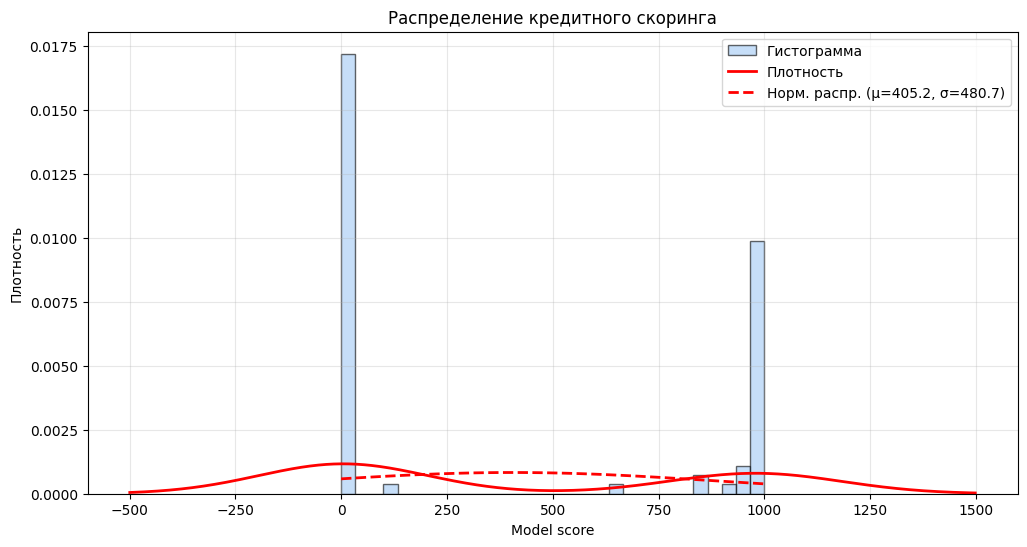

In [29]:
fig = plt.figure(figsize=(12, 6))

investigated_data = test_with_dates[test_with_dates["day"] == 22]

# Гистограмма + плотность распределения
investigated_data["model_score"].plot(
    kind="hist",
    bins=30,
    density=True,  # нормализация для наложения KDE
    alpha=0.6,
    edgecolor="black",
    label="Гистограмма",
)

# Добавляем KDE
investigated_data["model_score"].plot(
    kind="kde", linewidth=2, color="red", label="Плотность"
)


# Нормальное распределение (пунктирная линия)
mu = investigated_data["model_score"].mean()
sigma = investigated_data["model_score"].std()
x = np.linspace(
    investigated_data["model_score"].min(),
    investigated_data["model_score"].max(),
    100,
)
normal_dist = stats.norm.pdf(x, mu, sigma)

plt.plot(
    x,
    normal_dist,
    "r--",  # красная пунктирная линия
    linewidth=2,
    label=f"Норм. распр. (μ={mu:.1f}, σ={sigma:.1f})",
)


plt.xlabel("Model score")
plt.ylabel("Плотность")
plt.title("Распределение кредитного скоринга")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Распределение model score в течение одной конкретной недели 

In [30]:
test_with_dates["week"].unique()

<IntegerArray>
[14, 15, 16, 17, 18]
Length: 5, dtype: UInt32

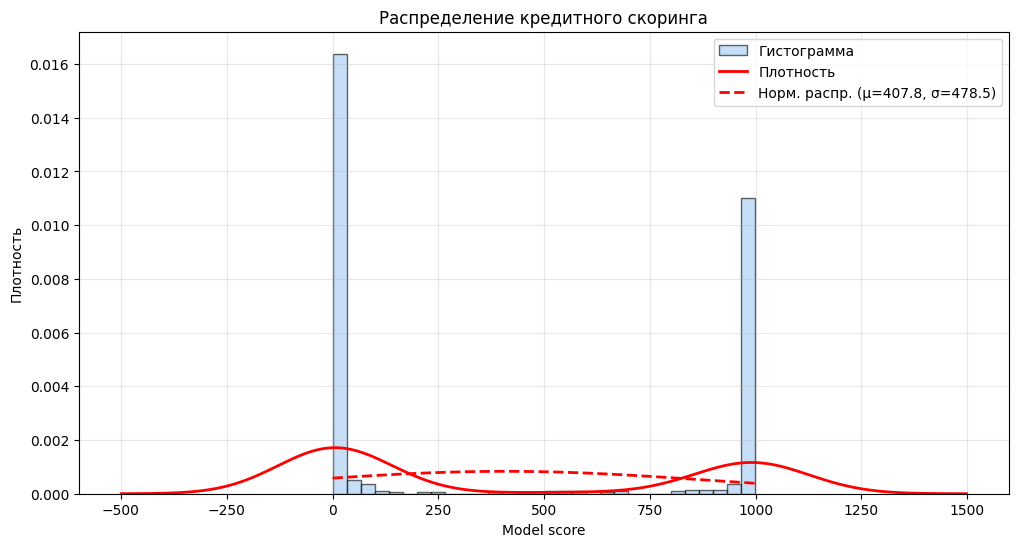

In [31]:
fig = plt.figure(figsize=(12, 6))

investigated_data = test_with_dates[test_with_dates["week"] == 16]

# Гистограмма + плотность распределения
investigated_data["model_score"].plot(
    kind="hist",
    bins=30,
    density=True,  # нормализация для наложения KDE
    alpha=0.6,
    edgecolor="black",
    label="Гистограмма",
)

# Добавляем KDE
investigated_data["model_score"].plot(
    kind="kde", linewidth=2, color="red", label="Плотность"
)


# Нормальное распределение (пунктирная линия)
mu = investigated_data["model_score"].mean()
sigma = investigated_data["model_score"].std()
x = np.linspace(
    investigated_data["model_score"].min(),
    investigated_data["model_score"].max(),
    100,
)
normal_dist = stats.norm.pdf(x, mu, sigma)

plt.plot(
    x,
    normal_dist,
    "r--",  # красная пунктирная линия
    linewidth=2,
    label=f"Норм. распр. (μ={mu:.1f}, σ={sigma:.1f})",
)


plt.xlabel("Model score")
plt.ylabel("Плотность")
plt.title("Распределение кредитного скоринга")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Попробуем нарисовать график распределения model 

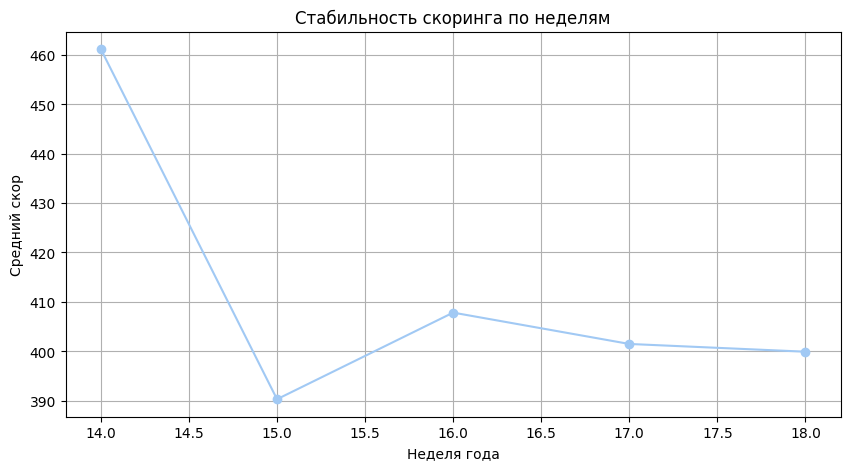

In [32]:
# Средний скор по неделям
week_avg = test_with_dates.groupby("week")["model_score"].mean()

plt.figure(figsize=(10, 5))
plt.plot(week_avg.index, week_avg.values, marker="o")
plt.title("Стабильность скоринга по неделям")
plt.xlabel("Неделя года")
plt.ylabel("Средний скор")
plt.grid(True)
plt.show()

In [33]:
# Кол-во бинов (интервалов скоринга)
bins = 10

# Разбиваем модельный скор на интервалы
bin_edges = np.linspace(
    test_with_dates["model_score"].min(), test_with_dates["model_score"].max(), bins + 1
).astype(int)

bin_labels = [f"{bin_edges[i]}-{bin_edges[i + 1]}" for i in range(len(bin_edges) - 1)]

test_with_dates["score_bin"] = pd.cut(
    test_with_dates["model_score"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True,
)

In [34]:
weekly_distribution = (
    (test_with_dates.groupby(["week", "score_bin"]).size())
    .groupby("week")
    .apply(lambda x: x / x.sum())
    .unstack(fill_value=0)
    .droplevel(0)
).reset_index()

/tmp/ipykernel_92146/2429446475.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (test_with_dates.groupby(["week", "score_bin"]).size())


In [35]:
weekly_distribution

score_bin,week,0-99,99-199,199-299,299-399,399-499,499-599,599-699,699-799,799-899,899-999
0,14,0.527273,0.000000,0.000000,0.006061,0.006061,0.000000,0.000000,0.006061,0.018182,0.436364
1,15,0.585106,0.010638,0.005319,0.008865,0.000000,0.000000,0.003546,0.008865,0.008865,0.368794
2,16,0.574871,0.005164,0.003442,0.001721,0.001721,0.010327,0.005164,0.000000,0.013769,0.383821
3,17,0.581034,0.006897,0.003448,0.003448,0.001724,0.001724,0.003448,0.001724,0.013793,0.382759
4,18,0.574324,0.006757,0.000000,0.006757,0.006757,0.000000,0.000000,0.020270,0.033784,0.351351


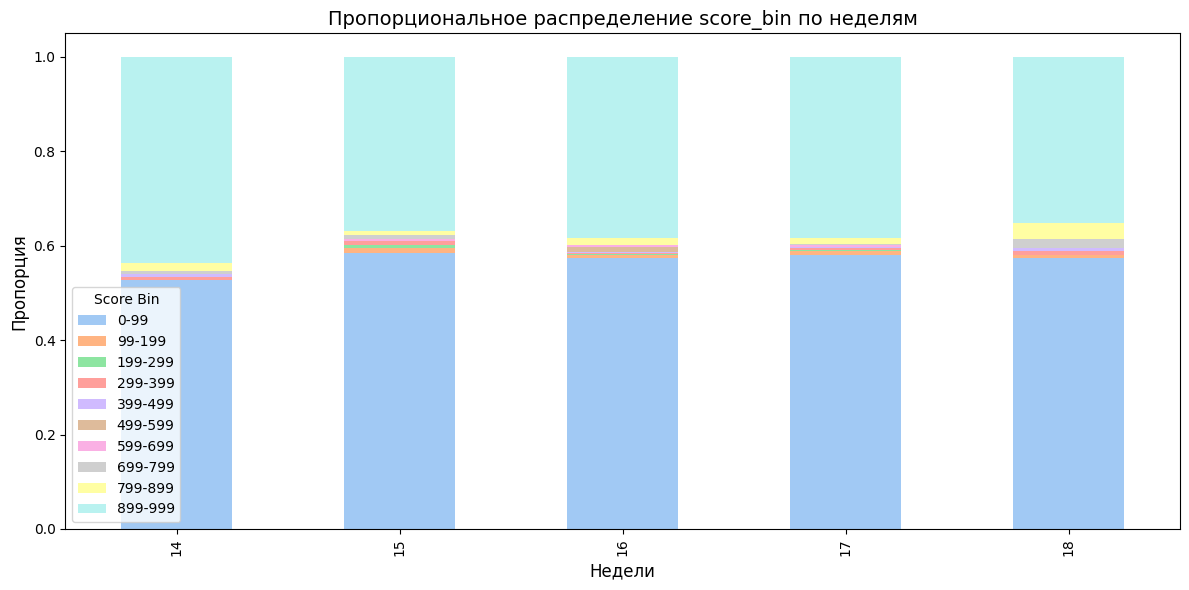

In [36]:
# Приведение данных в форму для stacked barplot , colormap="viridis")
weekly_distribution.set_index("week", inplace=True)
weekly_distribution.plot(kind="bar", stacked=True, figsize=(12, 6))

# Настройки графика
plt.title("Пропорциональное распределение score_bin по неделям", fontsize=14)
plt.xlabel("Недели", fontsize=12)
plt.ylabel("Пропорция", fontsize=12)
plt.legend(title="Score Bin")
plt.tight_layout()
plt.show()

Таблица доля одобрений 

In [37]:
proportion_cutoff = {"cutoff_value": [], "approval_rate": []}

for item in range(100, 1100, 100):
    proportion_cutoff.get("cutoff_value").append(item)
    proportion_cutoff.get("approval_rate").append(
        (
            test_with_dates.query(f"model_score < {item} and resolution == 1").shape[0]
            / test_with_dates.shape[0]
        )
        * 100
    )
proportion_cutoff = pd.DataFrame(proportion_cutoff)

proportion_cutoff

,cutoff_value,approval_rate
0,100,0.196271
1,200,0.196271
2,300,0.196271
3,400,0.294406
4,500,0.441609
5,600,0.686948
6,700,0.932287
7,800,1.226693
8,900,2.649657
9,1000,40.628067


In [39]:
import joblib

pth_preprocessor = Path("service/model")
pth_preprocessor.mkdir(exist_ok=True, parents=True)

joblib.dump(
    test_preprocessor.column_transformer, pth_preprocessor / "column_transformer.pkl"
)

joblib.dump(model, pth_preprocessor / "model.pkl")

['service/model/model.pkl']